## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Фахретдинов Владислав Станиславович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 26 февраля.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

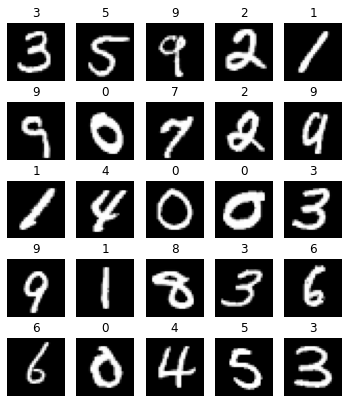

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

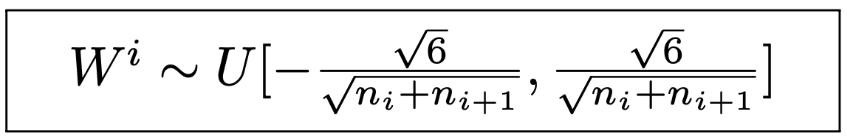

In [9]:
def init_layer_xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    uniform_range = 6 ** 0.5 / (weight.shape[0] + weight.shape[1]) ** 0.5
    weight.uniform_(-uniform_range, uniform_range)

In [18]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)
layer_1_xavier = nn.Linear(28*28, 500)
layer_2_xavier = nn.Linear(500, 10)
layer_1_xavier_torch = nn.Linear(28*28, 500)
layer_2_xavier_torch = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_1_xavier.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)
layer_2_xavier.register_forward_hook(forward_hook)
layer_1_xavier_torch.register_forward_hook(forward_hook)
layer_2_xavier_torch.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_1_xavier.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)
layer_2_xavier.register_backward_hook(backward_hook)
layer_1_xavier_torch.register_backward_hook(forward_hook)
layer_2_xavier_torch.register_backward_hook(forward_hook)

init_layer(layer_1)
init_layer(layer_2)
init_layer_xavier(layer_1_xavier)
init_layer_xavier(layer_2_xavier)
torch.nn.init.xavier_uniform(layer_1_xavier_torch.weight)
torch.nn.init.xavier_uniform(layer_2_xavier_torch.weight)
pass

/tmp/ipykernel_173008/2361226345.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer_1_xavier_torch.weight)
/tmp/ipykernel_173008/2361226345.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer_2_xavier_torch.weight)


In [11]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

In [12]:
network_xavier = nn.Sequential(
    layer_1_xavier,
    nn.Tanh(),
    layer_2_xavier
)

In [19]:
network_xavier_torch = nn.Sequential(
    layer_1_xavier_torch,
    nn.Tanh(),
    layer_2_xavier_torch
)

In [20]:
from tqdm import tqdm

In [25]:
for x, y in tqdm(train_loader):
    out = network(x.reshape(128, -1))
    loss = torch.norm(out)
    loss.backward()
    break

  0%|                                                   | 0/469 [00:00<?, ?it/s]

forward 1.0119094848632812
forward 0.9854973554611206
backward 1.9130041599273682
backward 0.21524301171302795


In [28]:
for x, y in tqdm(train_loader):
    out = network_xavier(x.reshape(128, -1))
    loss = torch.norm(out)
    loss.backward()
    break

  0%|                                                   | 0/469 [00:00<?, ?it/s]

forward 1.0036041736602783
forward 0.6527354121208191
backward 1.6880698204040527
backward 0.18822215497493744


In [29]:
for x, y in tqdm(train_loader):
    out = network_xavier_torch(x.reshape(128, -1))
    loss = torch.norm(out)
    loss.backward()    
    break

  0%|                                                   | 0/469 [00:00<?, ?it/s]

forward 1.0134825706481934
forward 0.6523779630661011
forward 2.1302475929260254
forward 0.23837780952453613


Непонятно, почему разница дисперсий у инициализации с помощью метода xavier больше

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

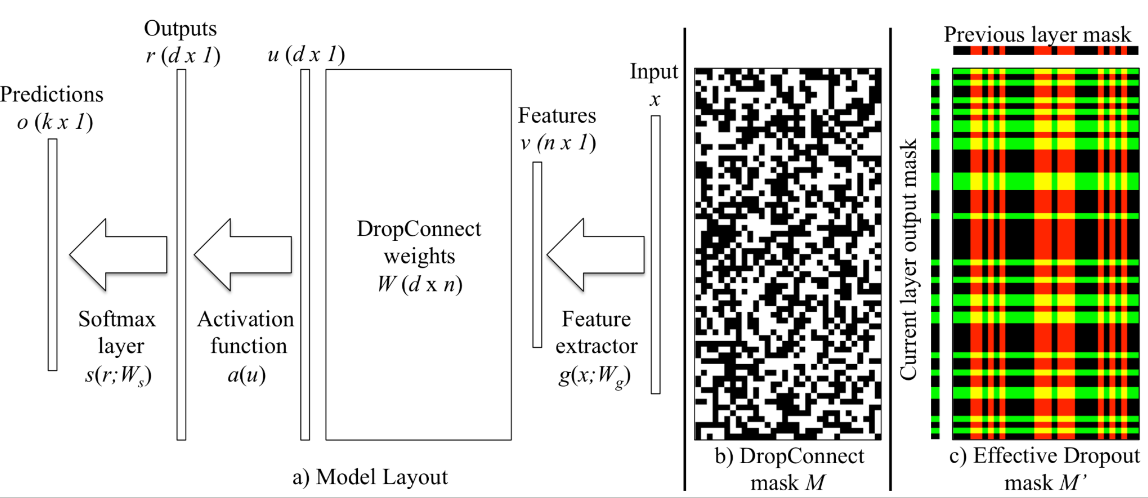

In [32]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p
        self.distribution = torch.distributions.Bernoulli(torch.FloatTensor([self.p]))

    def forward(self, x):
        if self.training:
            mask = self.distribution.sample(self.linear.weight.shape).squeeze(-1)
        else:
            mask = torch.ones_like(self.linear.weight)
        mask.requires_grad = False            
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [33]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [34]:
n = TestNetwork(())

Добавим несколько слоев в конец сети:

In [35]:
layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [123]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [49]:
def loop(network, optimizer):
    history = {'train': [], 'val': []}
    for epoch in range(10):
        network.train()
        run_loss = 0.0
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                
        history['train'].append(run_loss / len(train_loader))

        network.eval()
        losses = []
        run_loss = 0.0
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)
            run_loss += loss.item()

            losses.append(loss.item())

        history['val'].append(run_loss / len(test_loader))
        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(losses)))

    return history

In [43]:
def plot_hist(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history['train'], label='train loss')
    plt.plot(history['val'], label='val loss')
    plt.legend()
    plt.show()


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302018
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.352692
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.673352
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.623293
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.417671
Test Epoch: 0	Loss: 0.690854
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.324283
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.404210
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.411404
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.406573
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.207246
Test Epoch: 1	Loss: 0.492506
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.253404
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.325025
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.288259
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.219769
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.227612
Test Epoch: 2	Loss: 0.429204
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.219352
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.171708
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.167802
Train Epoch: 3 [38400/60000 (64%)

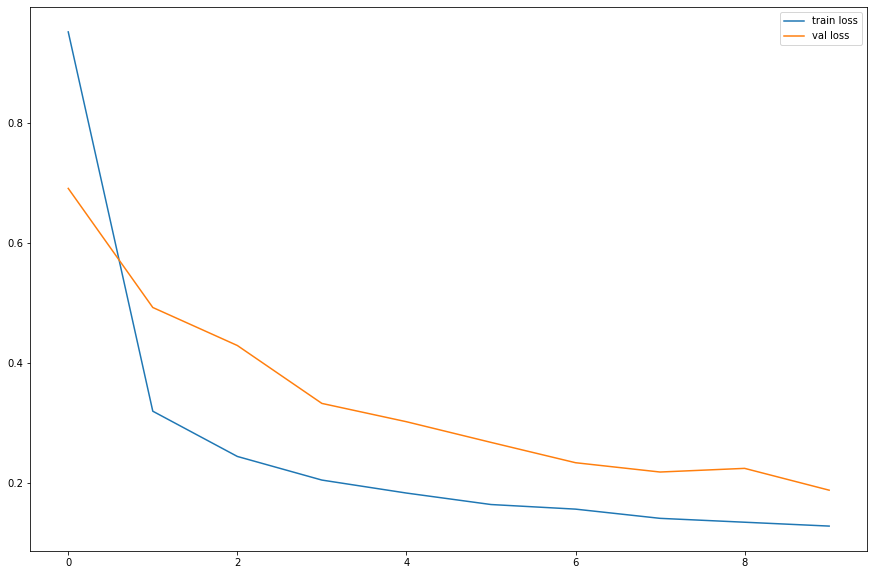

In [51]:
layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

hist = loop(network, optimizer)
plot_hist(hist)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305519
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.766243
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.540964
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.529194
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.377120
Test Epoch: 0	Loss: 0.211582
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.327437
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.410045
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.231644
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.234237
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.384546
Test Epoch: 1	Loss: 0.153592
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.259110
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.245707
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.228857
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.299366
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.239841
Test Epoch: 2	Loss: 0.118057
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.210213
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.183348
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.143213
Train Epoch: 3 [38400/60000 (64%)

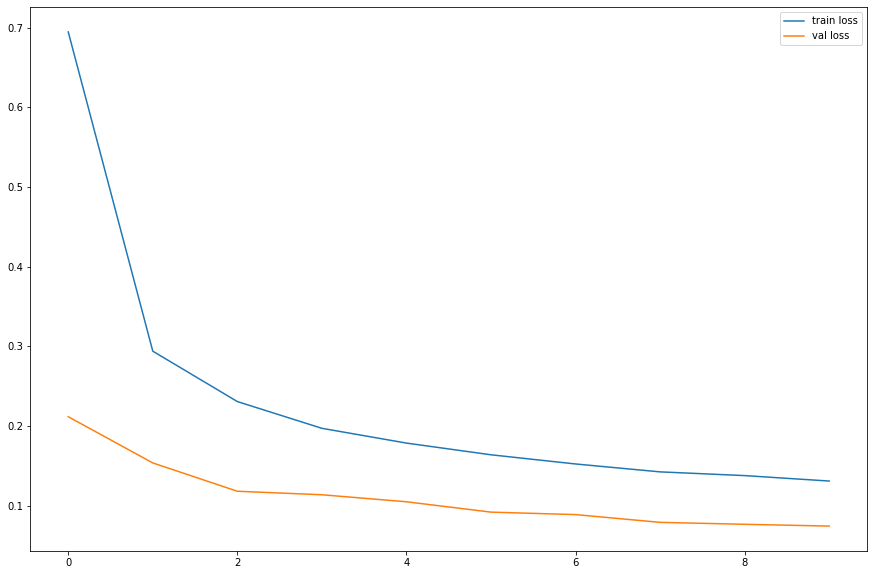

In [52]:
layers = [
    nn.Linear(196, 128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

hist = loop(network, optimizer)
plot_hist(hist)

**Вывод**: Сеть с Dropout сходится к лучшим значениям лосса, чем с DropConnect

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

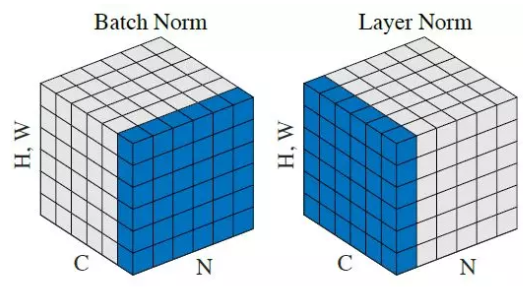

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [51]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims
        self.weight = torch.nn.Parameter(torch.ones(self.dims, requires_grad=True))
        self.bias = torch.nn.Parameter(torch.zeros(self.dims, requires_grad=True))
        
    def forward(self, x):
        output = (x - x.mean(dim=1)[:, None]) / (x.std(dim=1)[:, None] + 1e-8) * self.weight + self.bias
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.257482
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.339310
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.306767
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.132040
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.105712
Test Epoch: 0	Loss: 0.114167
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.138024
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.145954
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.081985
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.047361
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.045848
Test Epoch: 1	Loss: 0.088727
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.113717
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.092964
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.083684
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.061252
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.037184
Test Epoch: 2	Loss: 0.078478
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.053908
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.023273
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.028514
Train Epoch: 3 [38400/60000 (64%)

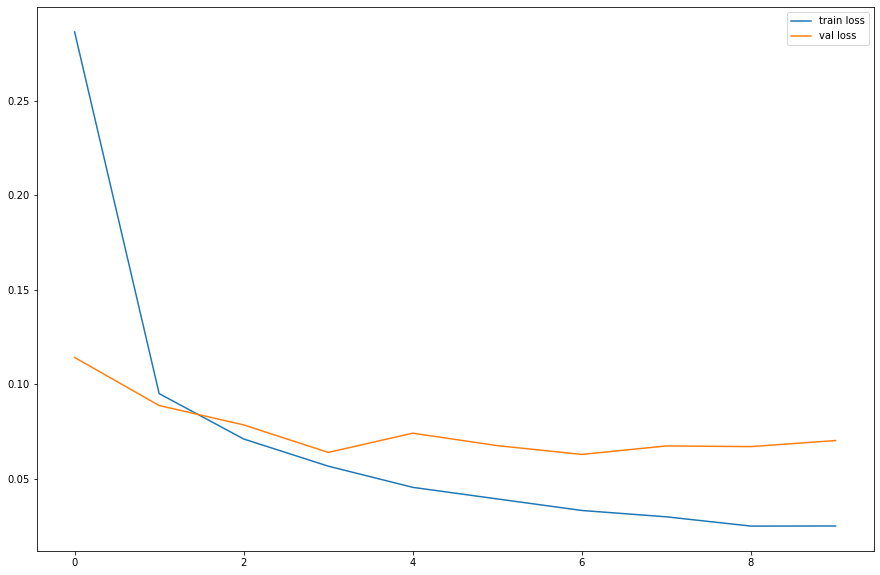

In [53]:
layers = [
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

hist = loop(network, optimizer)
plot_hist(hist)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.387150
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.329297
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.116460
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.195177
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.141788
Test Epoch: 0	Loss: 0.102268
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.092910
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.095067
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.086849
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.050785
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.075666
Test Epoch: 1	Loss: 0.062731
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023810
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.042183
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.051980
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.041939
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.056905
Test Epoch: 2	Loss: 0.070887
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.089438
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.015805
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.089145
Train Epoch: 3 [38400/60000 (64%)

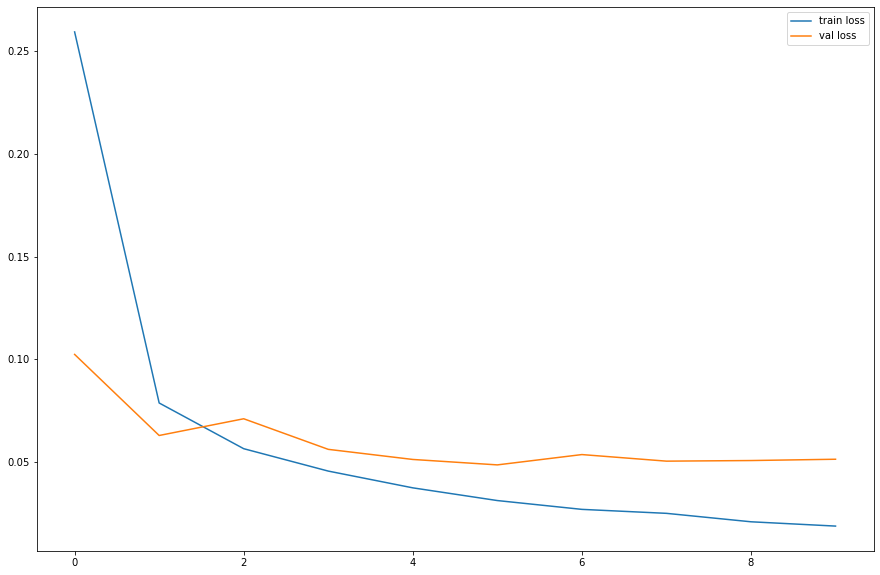

In [54]:
layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

hist = loop(network, optimizer)
plot_hist(hist)

**Вывод**: Поведение сетей с BN и LN не сильно отличается в данном примере